In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

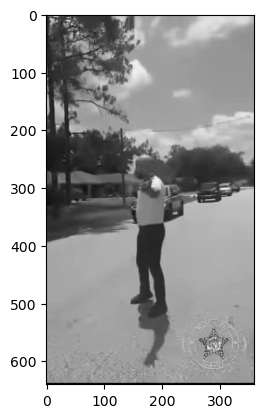

In [8]:
im_file = "C:\\Users\\USER\\Desktop\\D DRIVE\\Ulife\\23-24 sem1\\CS4243\\mini project images\\train\\weap\\0201866_20220828_carrying_2002_160.png"
img = cv2.imread(im_file, 0)
plt.imshow(img, cmap = 'gray')

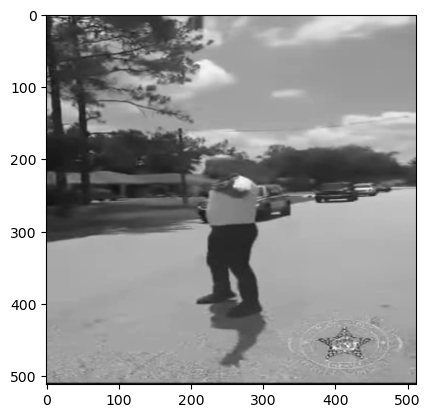

In [9]:
desired_size = (512, 512)
img_resized = cv2.resize(img, desired_size)
plt.imshow(img_resized, cmap = 'gray')

In [3]:
def gaussian_kernel(size, sigma=1.0):
    """Generate a Gaussian kernel of given size and standard deviation."""
    # Initialize an empty size x size array
    kernel = np.zeros((size, size))
    
    # Calculate the center position of the kernel
    center = size // 2
    
    # Loop through each element in the size x size array
    for x in range(0, size):
        for y in range(0, size):
            kernel[x][y] = 1 / (2 * np.pi * sigma * sigma) * np.exp((- (x - center) ** 2 - (y - center) ** 2) / 2 / sigma / sigma)
    
    # Normalize the kernel by dividing each element by the sum of all elements
    kernel = kernel / kernel.sum()
   
    return kernel


In [13]:
def load_images_from_directory(directory_path, desired_size=None):

    image_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    
    images = []
    for image_file in image_files:
        img_path = os.path.join(directory_path, image_file)
        

        img = cv2.imread(img_path)
        
        if desired_size:
            img = cv2.resize(img, desired_size)
        
        images.append(img)

    return images

In [ ]:
positive_images = load_images_from_directory('C:\\Users\\USER\\Desktop\\D DRIVE\\Ulife\\23-24 sem1\\CS4243\\mini project images\\train\\weap')
negative_images = load_images_from_directory('C:\\Users\\USER\\Desktop\\D DRIVE\\Ulife\\23-24 sem1\\CS4243\\mini project images\\train\\norm')

all_images = np.concatenate([positive_images, negative_images])

labels = np.concatenate([np.ones(len(positive_images)), np.zeros(len(negative_images))])

np.save('all_images.npy', all_images)
np.save('labels.npy', labels)

In [4]:
output1 = cv2.filter2D(src=img, ddepth=-1, kernel=gaussian_kernel(5))
output2 = cv2.GaussianBlur(img, (5, 5), 0)

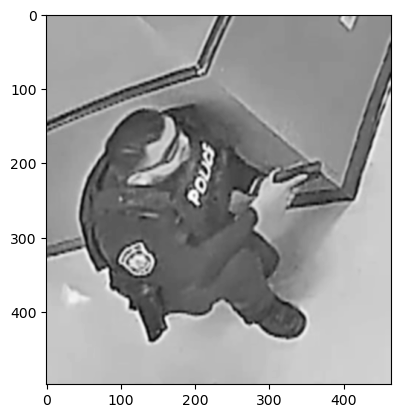

In [5]:
plt.imshow(output1, cmap = 'gray')

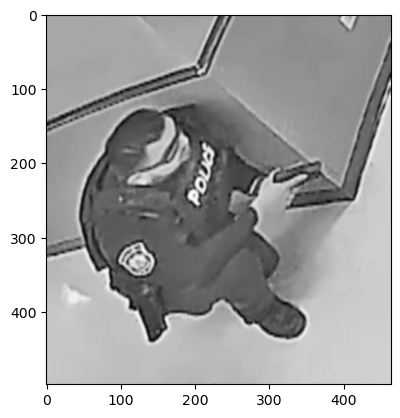

In [6]:
plt.imshow(output2, cmap = 'gray')

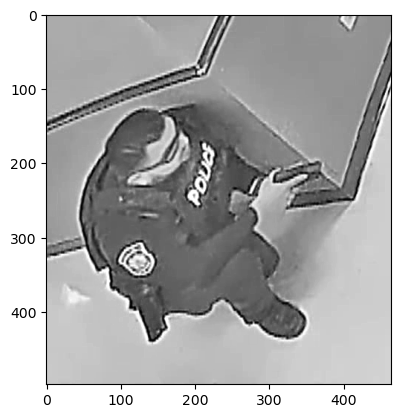

In [7]:
mask = cv2.subtract(img, output2)
mask_added = cv2.add(img, mask)
plt.imshow(mask_added, cmap = 'gray')

In [8]:
y_sobel_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
x_sobel_kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

In [9]:
Y_feature = cv2.filter2D(src=img, ddepth=-1, kernel=y_sobel_kernel)
X_feature = cv2.filter2D(src=img, ddepth=-1, kernel=x_sobel_kernel)

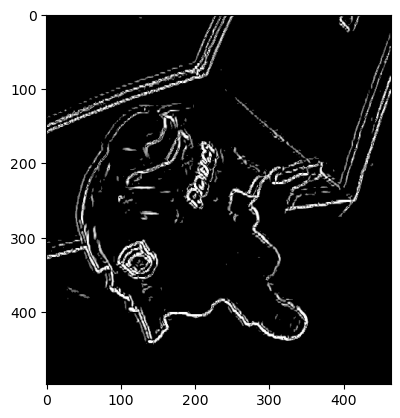

In [10]:
thr = 0.3
thr_Y=Y_feature.max()*thr
mask_Y=(Y_feature>thr_Y)
thr_X=X_feature.max()*thr
mask_X=(X_feature>thr_X)
Y_feature_thr=Y_feature.copy()*mask_Y
X_feature_thr=X_feature.copy()*mask_X
unified_feature=(Y_feature_thr+X_feature_thr)/2
plt.imshow(unified_feature, cmap = 'gray')

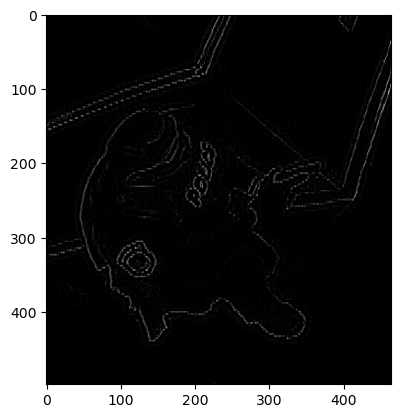

In [11]:
hp = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
output3 = cv2.filter2D(src=img, ddepth=-1, kernel=hp)
plt.imshow(output3, cmap = 'gray')

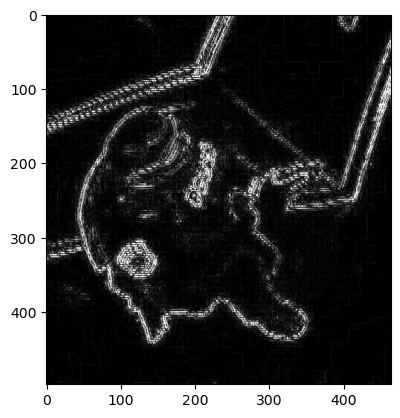

In [12]:
laplacian = cv2.Laplacian(img, cv2.CV_64F, ksize=3)
laplacian = cv2.convertScaleAbs(laplacian)
plt.imshow(laplacian, cmap = 'gray')

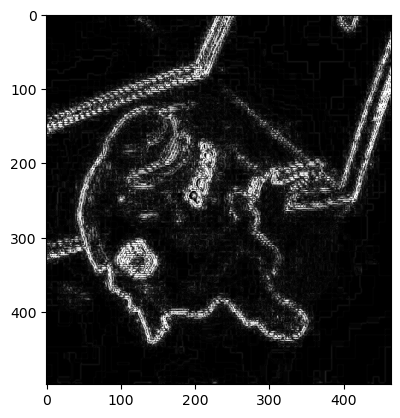

In [13]:
laplacian2 = cv2.Laplacian(mask_added, cv2.CV_64F, ksize=3)
laplacian2 = cv2.convertScaleAbs(laplacian2)
plt.imshow(laplacian2, cmap = 'gray')

In [14]:
def GaussLowPass(M, N, D0):
    filter = np.zeros((M, N))
    # normalized cut_off frequency is mapped to real index
    D0 = D0 * min(M,N) / 2
    for i in range(M):
        for j in range(N):
            d = ( (i-M/2)**2 + (j-N/2)**2 )**0.5
            filter[i,j]= np.exp(-((d/2/D0)**2) )
            
    return filter

def ButterworthLowPass(M, N, D0, n_o):
    #  
    filter = np.zeros((M, N))
    # normalized cut_off frequency is mapped to real index
    D0 = D0 * min(M,N) / 2
    n_o = 2 * n_o
    for i in range(M):
        for j in range(N):
            d = ( (i-M/2)**2 + (j-N/2)**2 )**0.5
            filter[i,j]= 1 / ( 1 + (d/D0)**n_o )
            
    return filter


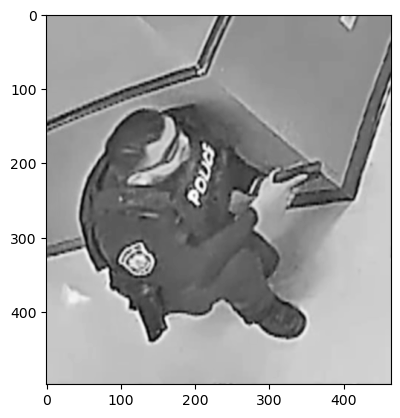

In [15]:
f_transform_c = np.fft.fft2(img)
f_transform_c = np.fft.fftshift(f_transform_c)
filtered_f_transform = np.multiply(f_transform_c, ButterworthLowPass(img.shape[0], img.shape[1], 0.5, 1))
filtered_image = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_f_transform)))
plt.imshow(filtered_image, cmap = 'gray')

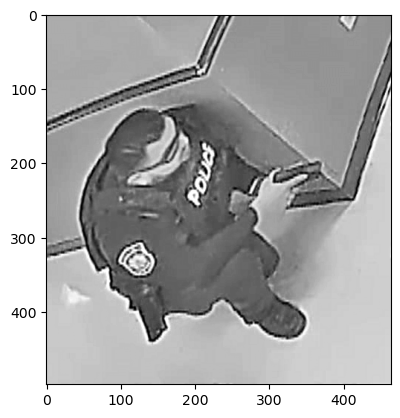

In [16]:
mask2 = cv2.subtract(img, filtered_image.astype('uint8'))
mask_added2 = cv2.add(img, mask2)
plt.imshow(mask_added2, cmap = 'gray')

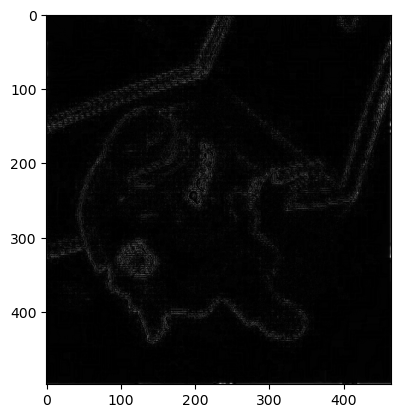

In [17]:
f_shift = np.fft.fft2(mask_added2)
f_shift = np.fft.fftshift(f_shift)
rows, cols = img.shape
crow, ccol = int(rows/2), int(cols/2)  
    
x = np.arange(-ccol, ccol)
y = np.arange(-crow, crow)
x, y = np.meshgrid(x, y)
    
laplacian_mask = -4 * np.pi**2 * (x**2 + y**2)

result_shift = f_shift * laplacian_mask
result = np.fft.ifftshift(result_shift)
result = np.abs(np.fft.ifft2(result))
plt.imshow(result, cmap = 'gray')

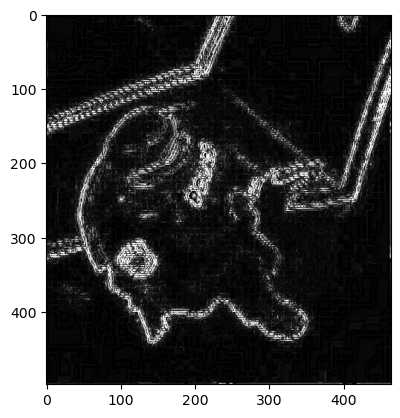

In [18]:
laplacian3 = cv2.Laplacian(mask_added2, cv2.CV_64F, ksize=3)
laplacian3 = cv2.convertScaleAbs(laplacian3)
plt.imshow(laplacian3, cmap = 'gray')

(<Axes: title={'center': 'High Pass 1'}>,
 Text(0.5, 1.0, 'High Pass 1'),
 (-0.5, 463.5, 497.5, -0.5))

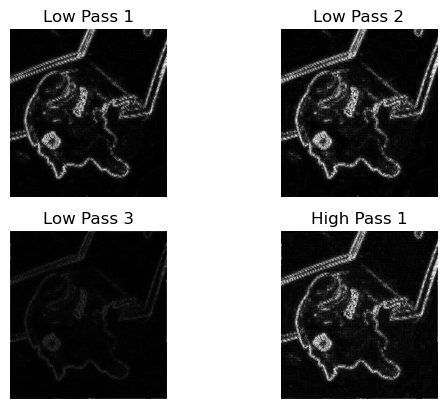

In [19]:
plt.subplot(221), plt.imshow(laplacian, cmap = 'gray'), plt.title('Low Pass 1'), plt.axis('off') 
plt.subplot(222), plt.imshow(laplacian2, cmap = 'gray'), plt.title('Low Pass 2') , plt.axis('off')
plt.subplot(223), plt.imshow(result, cmap = 'gray'), plt.title('Low Pass 3'), plt.axis('off')
plt.subplot(224), plt.imshow(laplacian3, cmap = 'gray'), plt.title('High Pass 1'), plt.axis('off')